<a href="https://colab.research.google.com/github/faranak5171/Deep-Learning-projects/blob/master/Cifar10_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import nn, optim
import torch.nn.functional as F

import warnings
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

trainset = datasets.CIFAR10('data', download=True, train=True, transform=transform)
testset = datasets.CIFAR10('data', download=True, train=False, transform=transform)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [3]:
val_size = 0.2
num_indices = len(trainset)
indices = list(range(num_indices))
np.random.shuffle(indices)
val_index = int(val_size*num_indices)
train_idx, val_idx = indices[val_index:], indices[:val_index]

train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

trainloader = DataLoader(trainset, batch_size=64, sampler=train_sampler)
valloader = DataLoader(trainset, batch_size=64, sampler=val_sampler)
testloader = DataLoader(testset, batch_size=64)

In [4]:
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck']

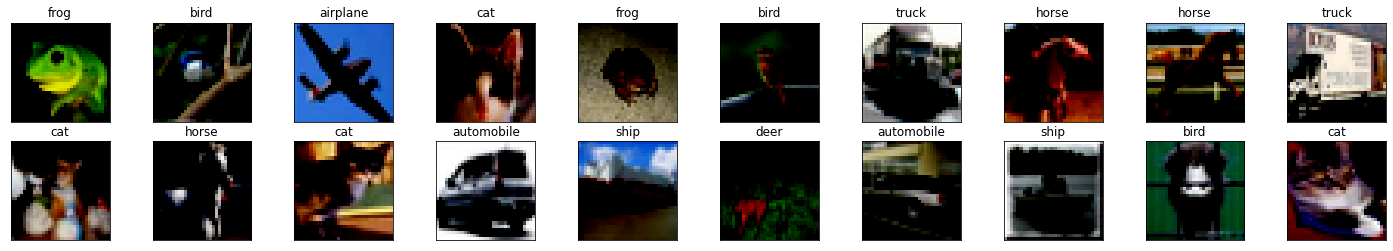

In [5]:
images, labels = next(iter(trainloader))
fig = plt.figure(figsize=(25,4))
for idx in range(20):
  ax = fig.add_subplot(2,10,idx+1, xticks=[], yticks=[])
  plt.imshow(utils.make_grid(images[idx]).permute(1,2,0))
  ax.set_title(classes[labels[idx]])
warnings.filterwarnings("ignore", category=FutureWarning)

In [11]:
class network(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
    self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
    self.conv3 = nn.Conv2d(32, 64, 3, padding=1)

    # Max pooling layer to reduce or half the size of input(width, height)
    self.pool = nn.MaxPool2d(2,2)
    # Fully connected layers
    self.fc1 = nn.Linear(1024, 500)
    self.fc2 = nn.Linear(500,10)
    self.dropout = nn.Dropout(0.25)

  def forward(self,x):
    # Input tensor in the shape of (3,32,32)
    x = self.pool(F.relu(self.conv1(x)))
    #print("output shape of conv1:",x.shape)
    x = self.pool(F.relu(self.conv2(x)))
    #print("output shape of conv2:",x.shape)
    x = self.pool(F.relu(self.conv3(x)))
    #print("output shape of conv3:",x.shape)

    # Flatten input
    x = x.view(-1,64*4*4)
    x = self.dropout(x)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.fc2(x)
    return x

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Input shape:{images.shape}")
model = network()
model.to(device)

Input shape:torch.Size([64, 3, 32, 32])


network(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [17]:
epochs = 30
running_loss = 0
valid_loss_min = np.Inf

for epoch in range(epochs):
  running_loss = 0
  valid_loss = 0

  model.train()
  for inputs,labels in trainloader:
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    output = model.forward(inputs)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()*inputs.size(0)
  
  model.eval()
  for inputs, labels in valloader:
    inputs, labels = inputs.to(device), labels.to(device)
    output = model.forward(inputs)
    loss = criterion(output, labels)
    valid_loss += loss.item()*inputs.size(0)

  print(f"Epoch: {epoch+1} training loss: {running_loss/len(trainloader.sampler):.3f}.. validation loss: {valid_loss/len(valloader.sampler):.3f} ")

  if valid_loss >= valid_loss_min:
    print("Validation loss decreased, stop training and save the model.")
    torch.save(model.state_dict(), 'cifar10_model.pt')
    break
  else:
    valid_loss_min = valid_loss


Epoch: 1 training loss: 0.811.. validation loss: 0.838 
Epoch: 2 training loss: 0.791.. validation loss: 0.833 
Epoch: 3 training loss: 0.777.. validation loss: 0.818 
Epoch: 4 training loss: 0.759.. validation loss: 0.801 
Epoch: 5 training loss: 0.743.. validation loss: 0.799 
Epoch: 6 training loss: 0.726.. validation loss: 0.788 
Epoch: 7 training loss: 0.714.. validation loss: 0.788 
Epoch: 8 training loss: 0.694.. validation loss: 0.773 
Epoch: 9 training loss: 0.684.. validation loss: 0.770 
Epoch: 10 training loss: 0.670.. validation loss: 0.764 
Epoch: 11 training loss: 0.653.. validation loss: 0.757 
Epoch: 12 training loss: 0.646.. validation loss: 0.755 
Epoch: 13 training loss: 0.629.. validation loss: 0.743 
Epoch: 14 training loss: 0.621.. validation loss: 0.763 
Validation loss decreased, stop training and save the model.


In [ ]:
# Test the model
